<a href="https://colab.research.google.com/github/ZenaNBamboat/MMAI5100_Applications_of_neural_networks/blob/main/PocketFM_Preliminary_Research_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PocketFM — Preliminary Research & EDA (Professor‑Proof)

This notebook is designed to run on **Google Colab** or locally. It includes:
- Clean data loading and validation
- Descriptive analytics (distributions, time trends, version analysis)
- Topic flags for monetization and stability complaints
- Optional sentiment analysis (VADER/TextBlob)
- Business‑oriented summaries to support Phase 1 of the project

> **How to use on Colab**
> 1. Upload `pocketfm_reviews_fullyear.csv` to Colab (left sidebar → Files → Upload), **or** mount Google Drive and point `DATA_PATH` to its location.
> 2. Run cells top‑to‑bottom. Each chart is a single plot, built with matplotlib only.


In [1]:

# (Colab only) Install optional libraries for sentiment
# If running locally and you already have these, you can skip
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install textblob==0.17.1 nltk==3.8.1
    import nltk
    nltk.download('vader_lexicon')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.0 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:

import os
import re
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Optional sentiment (works if installed)
try:
    from nltk.sentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
except Exception:
    VADER_AVAILABLE = False

plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_colwidth', 120)


## 1) Load Data

In [3]:

# Point to your CSV. On Colab, either upload to /content or mount Drive.
# If file not found, this cell prints guidance.
DEFAULT_PATHS = [
    "/content/pocketfm_reviews_fullyear.csv",  # Colab uploaded
    "/mnt/data/pocketfm_reviews_fullyear.csv", # ChatGPT sandbox (for reference)
    "pocketfm_reviews_fullyear.csv"            # local working dir
]

DATA_PATH = None
for p in DEFAULT_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError("CSV not found. Upload 'pocketfm_reviews_fullyear.csv' to Colab and re-run this cell.")

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

# heuristics for key columns
text_col = 'review_text' if 'review_text' in df.columns else None
rating_col = 'rating' if 'rating' in df.columns else None
date_col = 'date' if 'date' in df.columns else None
version_col = 'reviewcreatedversion' if 'reviewcreatedversion' in df.columns else None

print("Loaded:", DATA_PATH)
print("Rows:", len(df))
print("Columns:", list(df.columns))
print("Detected columns -> text:", text_col, "| rating:", rating_col, "| date:", date_col, "| version:", version_col)

df.head()


Loaded: /content/pocketfm_reviews_fullyear.csv
Rows: 100000
Columns: ['reviewid', 'username', 'rating', 'review_text', 'date', 'likes', 'reviewcreatedversion', 'show_title', 'genre']
Detected columns -> text: review_text | rating: rating | date: date | version: reviewcreatedversion


,reviewid,username,rating,review_text,date,likes,reviewcreatedversion,show_title,genre
0,b2aa38fc-c145-4dce-b390-19fadefc8398,Free Fire Top1,5,very very very good 👍👍😊😊,2025-10-05 10:11:58,0,8.7.4,PocketFM App,Audio Drama
1,78d9b23a-f918-4ed2-9205-34a6ea388c06,Sanskar Rajput,4,very good & mind freshing,2025-10-05 09:52:55,0,NaN,PocketFM App,Audio Drama
2,59746f29-0c42-4334-9834-35a3295c40d3,Rupam Marma,5,nice,2025-10-05 09:51:31,0,8.10.3,PocketFM App,Audio Drama
3,1279f401-8688-4081-9694-e47327bd0fe4,Umesh Dangi,5,nice story's,2025-10-05 09:44:35,0,8.10.3,PocketFM App,Audio Drama
4,88cb1d4d-121a-4573-84c2-f216e15d67d4,Prince Subedi,1,i don't want to give even one star but i gave. i have one dought why there is only sound no video,2025-10-05 09:39:42,0,8.10.3,PocketFM App,Audio Drama


## 2) Clean & Prepare

In [4]:

# Parse types
if rating_col:
    df[rating_col] = pd.to_numeric(df[rating_col], errors='coerce')

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Feature: review length
if text_col:
    df['review_len'] = df[text_col].astype(str).str.split().apply(len)

# Feature: churn proxy (ratings <= 2)
if rating_col:
    df['is_churn_risk'] = (df[rating_col] <= 2).astype(int)

# Keyword topic flags
def has_kw(text, patterns):
    if pd.isna(text):
        return False
    t = str(text).lower()
    return any(p in t for p in patterns)

if text_col:
    df['_ads'] = df[text_col].apply(lambda t: has_kw(t, [' ad ', ' ads', 'advert', 'advertis', 'ad-', 'ad.', 'too many ads', 'ad every', 'commercial']))
    df['_paywall'] = df[text_col].apply(lambda t: has_kw(t, ['paywall', 'subscription', 'subscribe', 'premium', 'coins', ' coin', 'purchase', 'buy']))
    df['_bugs'] = df[text_col].apply(lambda t: has_kw(t, ['bug', 'crash', 'lag', 'freeze', 'error', 'issue', 'login', 'glitch']))
    df['_support'] = df[text_col].apply(lambda t: has_kw(t, ['support', 'customer service', 'help', 'respond', 'refund']))

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewid              100000 non-null  object        
 1   username              99999 non-null   object        
 2   rating                100000 non-null  int64         
 3   review_text           99998 non-null   object        
 4   date                  100000 non-null  datetime64[ns]
 5   likes                 100000 non-null  int64         
 6   reviewcreatedversion  87518 non-null   object        
 7   show_title            100000 non-null  object        
 8   genre                 100000 non-null  object        
 9   review_len            100000 non-null  int64         
 10  is_churn_risk         100000 non-null  int64         
 11  _ads                  100000 non-null  bool          
 12  _paywall              100000 non-null  bool          
 13  

## 3) High‑Level Summary

In [5]:

summary_rows = []
summary_rows.append(["Total reviews", len(df)])
if rating_col:
    summary_rows.append(["Average rating", round(df[rating_col].mean(), 3)])
    summary_rows.append(["% ratings ≤ 2 (churn proxy)", f"{(df['is_churn_risk'].mean()*100):.1f}%"])
if text_col:
    for flag, label in [('_ads', 'ads'), ('_paywall','paywall/coins'), ('_bugs','bugs'), ('_support','support')]:
        if flag in df.columns:
            summary_rows.append([f"% reviews mentioning {label}", f"{(df[flag].mean()*100):.1f}%"])

summary_df = pd.DataFrame(summary_rows, columns=["Metric", "Value"])
summary_df


,Metric,Value
0,Total reviews,100000
1,Average rating,4.285
2,% ratings ≤ 2 (churn proxy),13.0%
3,% reviews mentioning ads,3.9%
4,% reviews mentioning paywall/coins,7.3%
5,% reviews mentioning bugs,2.5%
6,% reviews mentioning support,1.3%


## 4) Descriptive Visuals

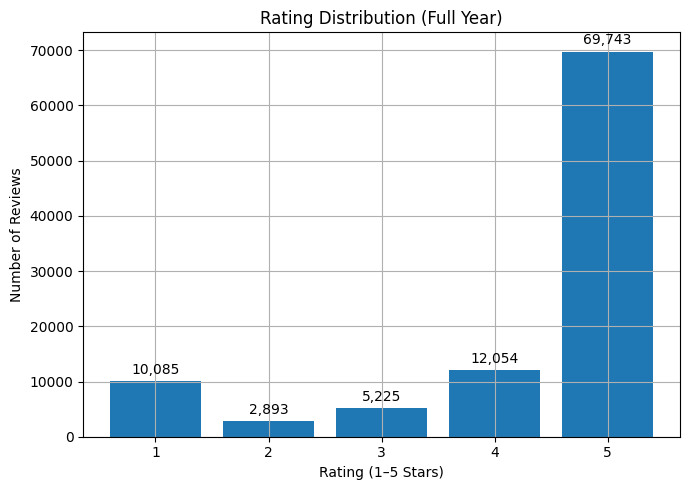

In [6]:

if rating_col:
    counts = df[rating_col].value_counts().sort_index()
    fig, ax = plt.subplots()
    bars = ax.bar(counts.index.astype(str), counts.values)
    ax.set_title("Rating Distribution (Full Year)")
    ax.set_xlabel("Rating (1–5 Stars)")
    ax.set_ylabel("Number of Reviews")
    ax.bar_label(bars, labels=[f"{v:,}" for v in counts.values], padding=3)
    plt.tight_layout()
    plt.show()


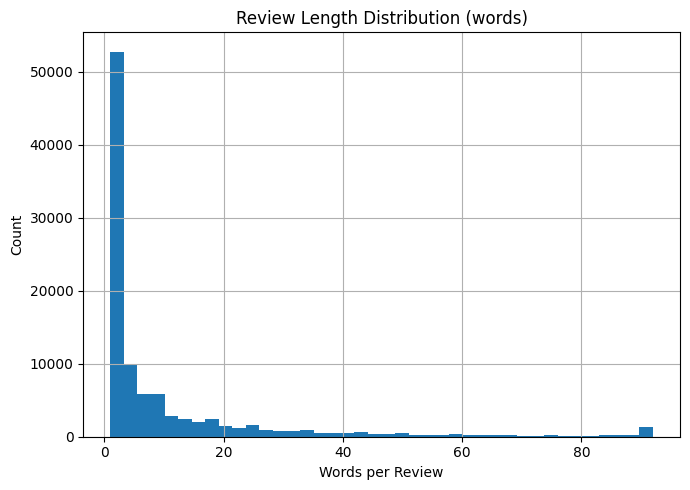

In [7]:

if text_col:
    # clamp long tails to make the histogram readable
    s = df['review_len'].clip(upper=df['review_len'].quantile(0.99))
    fig, ax = plt.subplots()
    ax.hist(s.dropna(), bins=40)
    ax.set_title("Review Length Distribution (words)")
    ax.set_xlabel("Words per Review")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-3079068154.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby(pd.Grouper(key=date_col, freq='M')).agg(


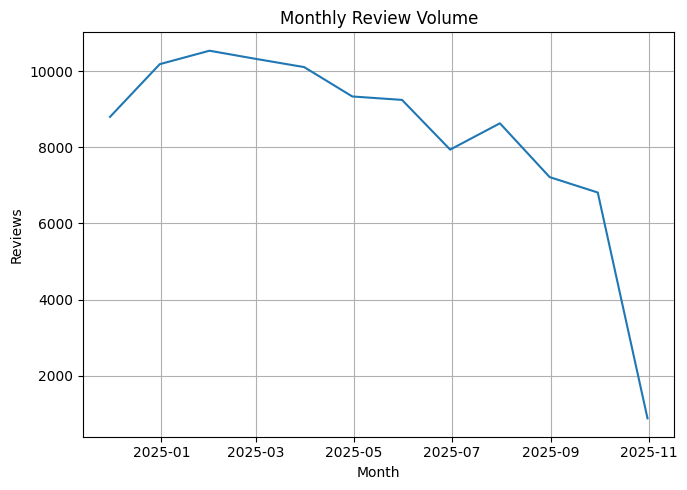

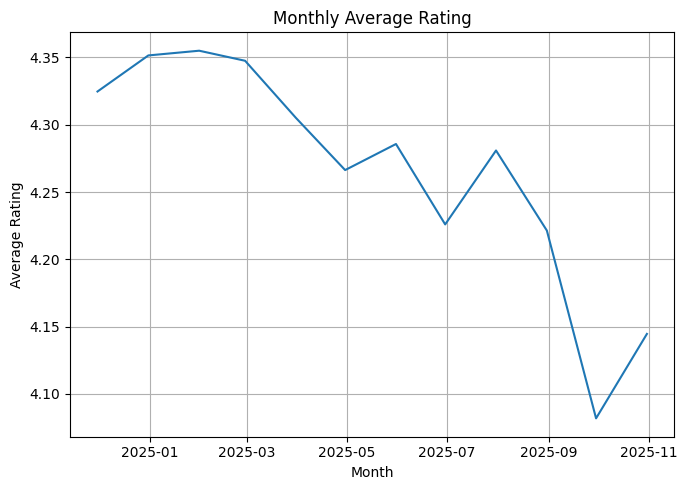

In [8]:

if date_col and rating_col:
    monthly = df.groupby(pd.Grouper(key=date_col, freq='M')).agg(
        reviews=(rating_col,'count'),
        avg_rating=(rating_col,'mean')
    ).reset_index()

    # Plot reviews per month
    fig, ax = plt.subplots()
    ax.plot(monthly[date_col], monthly['reviews'])
    ax.set_title("Monthly Review Volume")
    ax.set_xlabel("Month")
    ax.set_ylabel("Reviews")
    plt.tight_layout()
    plt.show()

    # Plot average rating per month
    fig, ax = plt.subplots()
    ax.plot(monthly[date_col], monthly['avg_rating'])
    ax.set_title("Monthly Average Rating")
    ax.set_xlabel("Month")
    ax.set_ylabel("Average Rating")
    plt.tight_layout()
    plt.show()


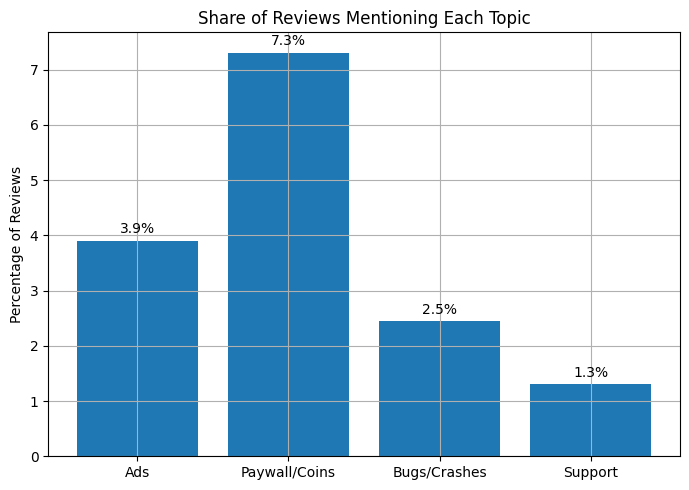

In [9]:

if text_col:
    topic_cols = [c for c in ['_ads','_paywall','_bugs','_support'] if c in df.columns]
    if topic_cols:
        counts = df[topic_cols].mean().rename(index={'_ads':'Ads','_paywall':'Paywall/Coins','_bugs':'Bugs/Crashes','_support':'Support'})
        fig, ax = plt.subplots()
        bars = ax.bar(counts.index, (counts.values*100))
        ax.set_title("Share of Reviews Mentioning Each Topic")
        ax.set_ylabel("Percentage of Reviews")
        ax.bar_label(bars, labels=[f"{v:.1f}%" for v in counts.values*100], padding=3)
        plt.tight_layout()
        plt.show()


,Group,Average Rating,n
0,All Reviews,4.284770,100000
1,Mentions Ads,2.866803,3904
2,Mentions Paywall/Coins,2.917510,7310
3,Mentions Bugs/Crashes,2.784346,2453
4,Mentions Support,2.988506,1305


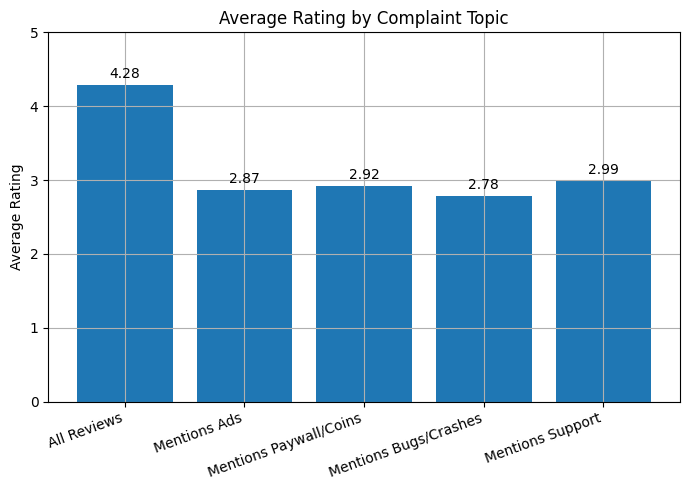

In [10]:

if rating_col and text_col:
    rows = []
    overall = df[rating_col].mean()
    rows.append(["All Reviews", overall, len(df)])
    for col, lbl in [('_ads','Mentions Ads'), ('_paywall','Mentions Paywall/Coins'),
                     ('_bugs','Mentions Bugs/Crashes'), ('_support','Mentions Support')]:
        if col in df.columns and df[col].any():
            val = df.loc[df[col], rating_col].mean()
            n = int(df[col].sum())
            rows.append([lbl, val, n])
    impact = pd.DataFrame(rows, columns=["Group","Average Rating","n"])

    # table
    display(impact)

    # simple bar chart
    fig, ax = plt.subplots()
    bars = ax.bar(impact['Group'], impact['Average Rating'])
    ax.set_ylim(0, 5)
    ax.set_title("Average Rating by Complaint Topic")
    ax.set_ylabel("Average Rating")
    ax.bar_label(bars, labels=[f"{v:.2f}" for v in impact['Average Rating']], padding=3, rotation=0)
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()


,reviewcreatedversion,reviews,avg_rating
167,7.8.3,6899,4.327584
134,7.1.2,5427,4.410908
148,7.5.4,5246,4.348456
143,7.4.1,5146,4.417800
131,7.0.2,4156,4.353946
189,8.2.3,3996,4.320821
205,8.4.9,3830,4.334204
155,7.6.6,3404,4.309636
128,6.9.2,3160,4.423734
139,7.2.4,2987,4.396719


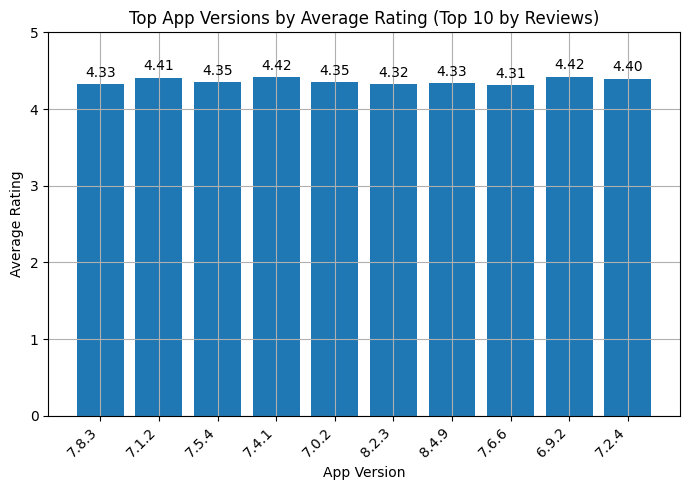

In [11]:

if version_col and rating_col:
    topv = df.groupby(version_col)[rating_col].agg(['count','mean']).reset_index()
    topv = topv.sort_values('count', ascending=False).head(10).rename(columns={'count':'reviews','mean':'avg_rating'})
    display(topv)

    fig, ax = plt.subplots()
    bars = ax.bar(topv[version_col].astype(str), topv['avg_rating'])
    ax.set_ylim(0,5)
    ax.set_title("Top App Versions by Average Rating (Top 10 by Reviews)")
    ax.set_xlabel("App Version")
    ax.set_ylabel("Average Rating")
    plt.xticks(rotation=45, ha='right')
    ax.bar_label(bars, labels=[f"{v:.2f}" for v in topv['avg_rating']], padding=3)
    plt.tight_layout()
    plt.show()


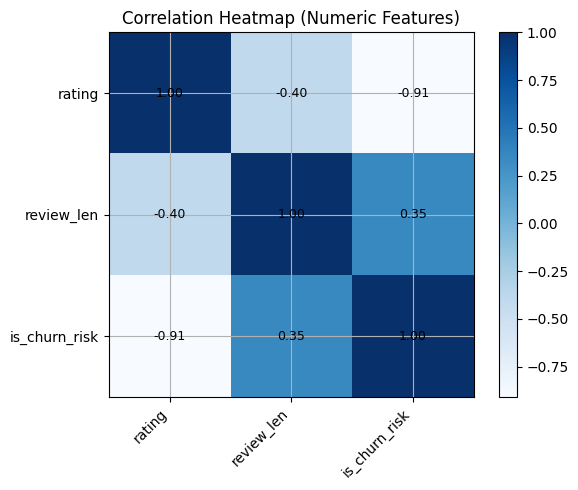

In [12]:

num_cols = []
if rating_col: num_cols.append(rating_col)
for c in ['review_len','is_churn_risk']:
    if c in df.columns: num_cols.append(c)

if num_cols:
    corr = df[num_cols].corr(numeric_only=True)
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values, cmap='Blues')
    ax.set_xticks(range(len(num_cols))); ax.set_xticklabels(num_cols, rotation=45, ha='right')
    ax.set_yticks(range(len(num_cols))); ax.set_yticklabels(num_cols)
    for i in range(len(num_cols)):
        for j in range(len(num_cols)):
            ax.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=9)
    ax.set_title("Correlation Heatmap (Numeric Features)")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


## 5) Optional: Sentiment Snapshot (VADER)

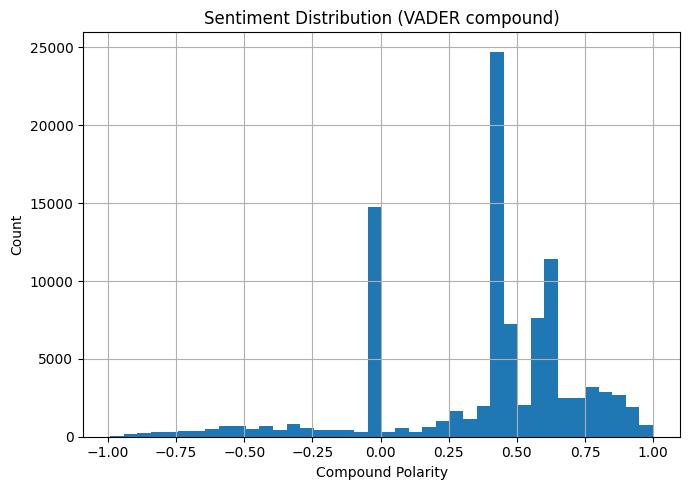

/tmp/ipython-input-2681362197.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ms = df.groupby(pd.Grouper(key=date_col, freq='M'))['sent_compound'].mean().reset_index()


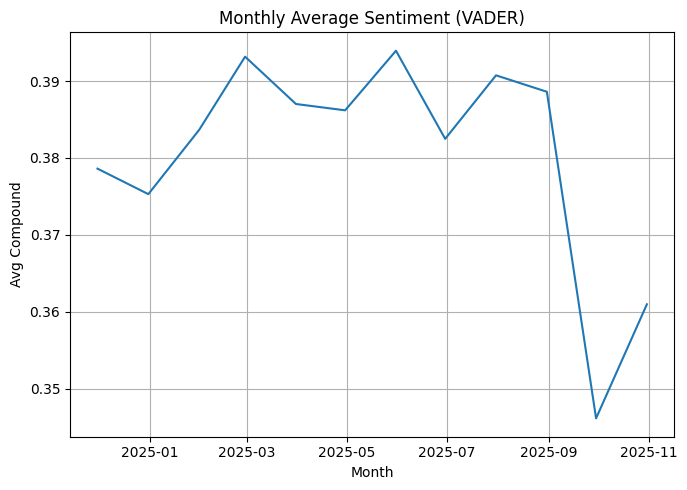

In [13]:

if text_col and VADER_AVAILABLE:
    sia = SentimentIntensityAnalyzer()
    df['sent_compound'] = df[text_col].astype(str).apply(lambda t: sia.polarity_scores(t)['compound'])
    # Distribution
    fig, ax = plt.subplots()
    ax.hist(df['sent_compound'].dropna(), bins=40)
    ax.set_title("Sentiment Distribution (VADER compound)")
    ax.set_xlabel("Compound Polarity")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Monthly sentiment
    if date_col:
        ms = df.groupby(pd.Grouper(key=date_col, freq='M'))['sent_compound'].mean().reset_index()
        fig, ax = plt.subplots()
        ax.plot(ms[date_col], ms['sent_compound'])
        ax.set_title("Monthly Average Sentiment (VADER)")
        ax.set_xlabel("Month")
        ax.set_ylabel("Avg Compound")
        plt.tight_layout()
        plt.show()
else:
    print("VADER sentiment not available in this environment. On Colab, run the install cell above.")


## 6) Key Insights (Auto‑Summary)

In [14]:

insights = []

if rating_col:
    overall = df[rating_col].mean()
    churn = df['is_churn_risk'].mean()*100 if 'is_churn_risk' in df.columns else None
    insights.append(f"Overall average rating is {overall:.2f}.")
    if churn is not None:
        insights.append(f"About {churn:.1f}% of reviews are 2 stars or less (churn proxy).")

if text_col and rating_col:
    for col, lbl in [('_ads','ads'),('_paywall','paywall/coins'),('_bugs','bugs/crashes'),('_support','support')]:
        if col in df.columns and df[col].any():
            avg = df.loc[df[col], rating_col].mean()
            n = int(df[col].sum())
            insights.append(f"When reviews mention {lbl}, the average rating is {avg:.2f} (n={n}).")

print("\n".join(f"- {s}" for s in insights) if insights else "No insights computed.")


- Overall average rating is 4.28.
- About 13.0% of reviews are 2 stars or less (churn proxy).
- When reviews mention ads, the average rating is 2.87 (n=3904).
- When reviews mention paywall/coins, the average rating is 2.92 (n=7310).
- When reviews mention bugs/crashes, the average rating is 2.78 (n=2453).
- When reviews mention support, the average rating is 2.99 (n=1305).



## 7) Business Interpretation & Next Steps

- **Monetization friction** appears closely tied to low ratings; prioritize an experiment on **ad‑frequency caps** and **coins/paywall UX clarity**.
- **Stability complaints** (crash/login) warrant focused QA and a short in‑app support path; re‑engage affected users after fixes.
- Track: retention rate of low‑rating cohorts, topic prevalence over time, average rating post‑intervention, and cost‑benefit (short‑term ad revenue vs. long‑term LTV).

**Planned causal work (Phase 2):**
- Version‑based pre/post comparisons for average rating and topic prevalence.
- Randomized A/B tests for ad frequency and paywall copy.
- Segment analysis by show/genre to prioritize interventions.
